# 11.2. Attention Pooling by Similarity

## 11.2.1. Kernels and Data

Attention Pooling by Similarity 是一种基于相似度的注意力汇聚方法，它将传统的注意力机制与特征汇聚（pooling）结合在一起，通过计算相似度来为输入序列中的每个元素分配不同的权重，从而实现更加灵活和自适应的汇聚方式。

In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

d2l.use_svg_display()

在 D2L（Dive into Deep Learning）课程的第 11.2 章中，提到了注意力机制中的“内核”（Kernel）和“数据”（Data）两个概念，这里的“内核”指的是不同的核函数（kernel functions）用于计算相似性或注意力权重。以下是对几种内核的解释：

### 1. **高斯内核（Gaussian Kernel）**
高斯内核（也称为径向基函数核，RBF kernel）是最常见的一种核函数，它根据输入向量的距离来计算相似性。对于注意力机制，**高斯内核**的作用是根据查询向量和键向量之间的距离来计算权重，较近的输入项会分配较高的权重，远的项权重较低。

公式如下：
$$
K(x, x') = \exp \left( - \frac{{\| x - x' \|^2}}{{2 \sigma^2}} \right)
$$
其中，\( x \) 和 \( x' \) 分别代表查询和键向量，\( \sigma \) 控制了内核的宽度。

**特点**：
- 对距离敏感，能够捕捉局部相似性。
- 通常用于平滑处理，可以生成平滑的注意力权重分布。

### 2. **Boxcar 内核**
Boxcar 内核是一种简单的、非平滑的内核。它只对在一定范围内的输入分配相等的权重，范围之外的输入直接忽略。它的形式类似于一个矩形窗口，因此也称为矩形内核或窗口内核。

公式如下：
$$
K(x, x') = 
\begin{cases}
1, & \text{if } |x - x'| \leq h \\
0, & \text{otherwise}
\end{cases}
$$
其中 \( h \) 是窗口的宽度参数。

**特点**：
- 在定义的范围内，所有元素得到相等的权重，没有平滑效果。
- 超出范围的元素直接忽略。

### 3. **常数内核（Constant Kernel）**
常数内核是最简单的一种内核函数，它为所有输入分配相等的注意力权重，完全忽略查询和键向量之间的相似性或距离。因此，它在所有位置上都分配了相同的权重，没有任何偏向。

公式如下：
$$
K(x, x') = c
$$
其中 \( c \) 是一个常数，可以设定为 1。

**特点**：
- 没有相似性或距离信息的考虑，分配均匀的权重。
- 非常简单，但是忽略了序列中的差异性，通常不适合复杂的场景。

### 4. **Epanechikov 内核**
Epanechikov 内核是一种常见的核函数，用于平滑数据。它也被称为抛物线核或二次核。与高斯核类似，它也随着输入项之间的距离增加而减小权重，但是它在距离为 0 的地方分配最大的权重，然后随着距离的增加呈二次方下降。

公式如下：
$$
K(x, x') = 
\begin{cases}
\frac{3}{4}(1 - \frac{{(x - x')^2}}{h^2}), & \text{if } |x - x'| \leq h \\
0, & \text{otherwise}
\end{cases}
$$
其中 \( h \) 是带宽参数。

**特点**：
- 对近邻数据分配较高权重，并且权重呈抛物线形式逐渐衰减。
- 比高斯核更为局部化，适合捕捉局部特征。

### **总结内核的作用**

这些内核函数在注意力机制中的作用是决定如何根据查询和键向量之间的相似性或距离来分配注意力权重。不同的核函数可以产生不同的权重分布，从而影响模型对不同输入元素的关注程度：

- **高斯内核**更适合平滑的注意力分布。
- **Boxcar 内核**用于分配固定范围内的均匀权重。
- **常数内核**忽略距离信息，分配相同的权重。
- **Epanechikov 内核**用于平滑且局部化的权重分布。

这些核函数提供了不同的机制来处理序列数据中的相似性关系，适用于不同的任务和场景。


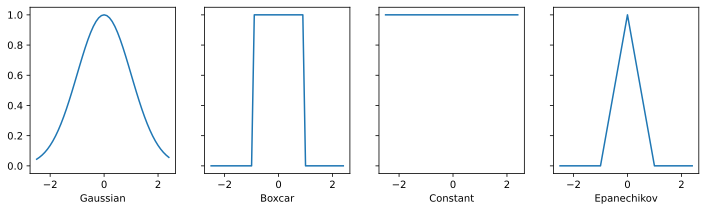

In [2]:
# Define some kernels
def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

d2l.plt.show()

In [3]:
def f(x):
    return 2 * torch.sin(x) + x

In [4]:
n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
x_train

tensor([0.4444, 0.5554, 0.5716, 0.9419, 0.9551, 1.1486, 1.3498, 1.4471, 1.4939,
        1.6749, 1.9895, 2.0724, 2.1670, 2.2609, 2.2706, 2.3600, 2.4337, 2.4897,
        2.4974, 2.5208, 2.5394, 2.5899, 2.6387, 2.8834, 2.9049, 2.9862, 3.1304,
        3.3295, 3.4928, 3.4950, 3.6473, 3.6672, 3.7077, 3.9081, 4.0469, 4.0610,
        4.3820, 4.4489, 4.6928, 4.9332])

In [6]:

y_train = f(x_train) + torch.randn(n)
y_train


tensor([1.9514, 1.0848, 1.6737, 1.6429, 2.9616, 3.0883, 2.8436, 4.4466, 3.5383,
        3.3698, 2.4844, 5.9160, 5.3432, 3.5756, 2.2865, 3.9410, 2.9130, 1.8081,
        3.9166, 4.2400, 3.5250, 3.5492, 4.3164, 3.1749, 4.7327, 2.7698, 3.2271,
        3.4766, 1.8500, 3.2598, 4.9271, 4.2957, 5.0093, 1.3587, 3.4191, 3.6804,
        0.7030, 0.7422, 2.4615, 2.1849])

In [7]:
x_val = torch.arange(0, 5, 0.1)
x_val


tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
        2.7000, 2.8000, 2.9000, 3.0000, 3.1000, 3.2000, 3.3000, 3.4000, 3.5000,
        3.6000, 3.7000, 3.8000, 3.9000, 4.0000, 4.1000, 4.2000, 4.3000, 4.4000,
        4.5000, 4.6000, 4.7000, 4.8000, 4.9000])

In [9]:
y_val = f(x_val)
y_val

tensor([0.0000, 0.2997, 0.5973, 0.8910, 1.1788, 1.4589, 1.7293, 1.9884, 2.2347,
        2.4667, 2.6829, 2.8824, 3.0641, 3.2271, 3.3709, 3.4950, 3.5991, 3.6833,
        3.7477, 3.7926, 3.8186, 3.8264, 3.8170, 3.7914, 3.7509, 3.6969, 3.6310,
        3.5548, 3.4700, 3.3785, 3.2822, 3.1832, 3.0833, 2.9845, 2.8889, 2.7984,
        2.7150, 2.6403, 2.5763, 2.5245, 2.4864, 2.4634, 2.4568, 2.4677, 2.4968,
        2.5449, 2.6126, 2.7002, 2.8077, 2.9351])

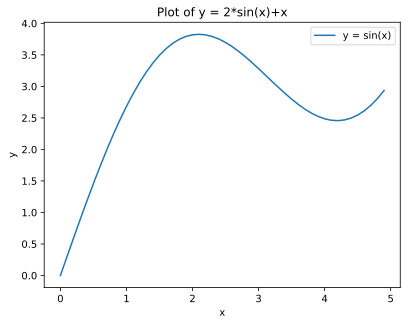

In [18]:
import matplotlib.pyplot as plt

plt.plot(x_val, y_val, label='y = sin(x)')
plt.xlabel('x')         # Label for x-axis
plt.ylabel('y')         # Label for y-axis
plt.title('Plot of y = 2*sin(x)+x')  # Title of the plot

plt.legend()
plt.show()

In [19]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # Each column/row corresponds to each query/key
    k = kernel(dists).type(torch.float32)
    # Normalization over keys for each query
    attention_w = k / k.sum(0)
    y_hat = y_train@attention_w
    return y_hat, attention_w

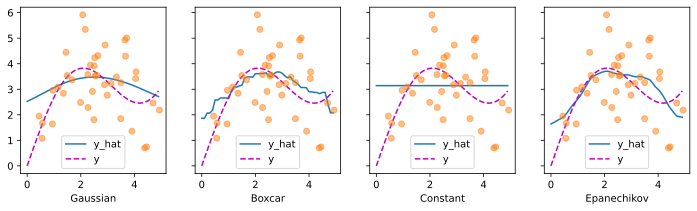

In [20]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train, y_train, x_val, y_val, kernels, names)